# <center>UrbanSound8K</center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries-Import" data-toc-modified-id="Libraries-Import-1">Libraries Import</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2">Parameters</a></span></li><li><span><a href="#Import-of-the-Metadata-File" data-toc-modified-id="Import-of-the-Metadata-File-3">Import of the Metadata File</a></span></li><li><span><a href="#Creation-of-the-Dataset-Class" data-toc-modified-id="Creation-of-the-Dataset-Class-4">Creation of the Dataset Class</a></span></li><li><span><a href="#Instantiation-of-the-Dataset" data-toc-modified-id="Instantiation-of-the-Dataset-5">Instantiation of the Dataset</a></span></li><li><span><a href="#Dataset-Exploration" data-toc-modified-id="Dataset-Exploration-6">Dataset Exploration</a></span><ul class="toc-item"><li><span><a href="#Classes-Counts" data-toc-modified-id="Classes-Counts-6.1">Classes Counts</a></span></li><li><span><a href="#Duration-of-Events" data-toc-modified-id="Duration-of-Events-6.2">Duration of Events</a></span></li><li><span><a href="#Salience" data-toc-modified-id="Salience-6.3">Salience</a></span><ul class="toc-item"><li><span><a href="#Global" data-toc-modified-id="Global-6.3.1">Global</a></span></li><li><span><a href="#Per-Class" data-toc-modified-id="Per-Class-6.3.2">Per Class</a></span></li></ul></li><li><span><a href="#Folds-Distribution" data-toc-modified-id="Folds-Distribution-6.4">Folds Distribution</a></span></li><li><span><a href="#Visualition-of-an-Event" data-toc-modified-id="Visualition-of-an-Event-6.5">Visualition of an Event</a></span></li></ul></li><li><span><a href="#Creation-of-the-Model" data-toc-modified-id="Creation-of-the-Model-7">Creation of the Model</a></span></li><li><span><a href="#Creation-of-the-Pipeline" data-toc-modified-id="Creation-of-the-Pipeline-8">Creation of the Pipeline</a></span></li><li><span><a href="#Model-Training-and-Validation" data-toc-modified-id="Model-Training-and-Validation-9">Model Training and Validation</a></span></li></ul></div>

## Libraries Import

In [1]:
import os
import math
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torchmetrics import Accuracy, Precision, Recall, F1, ConfusionMatrix
import torchaudio
import torchaudio.transforms as transforms
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Parameters

In [2]:
########################################################################
dataset_path = "dataset"
########################################################################
# Choose the device to operate on
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Used device: {device}")
########################################################################
# Transforms parameters
target_sample_rate = 22050
target_length = 4
n_samples = target_length * target_sample_rate
n_fft = 512
transforms_params = {
    "target_sample_rate": target_sample_rate,
    "target_length": target_length,
    "n_samples": n_samples,
    "n_fft": n_fft,
}

Used device: cuda


## Import of the Metadata File

In [3]:
metadata = pd.read_csv("dataset/UrbanSound8K.csv")
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


## Creation of the Dataset Class

In [4]:
class UrbanSound8K(Dataset):
    
    def __init__(self, metadata, dataset_path, transforms_params, device):
        self.device = device
        self.metadata = metadata
        self.dataset_path = dataset_path
        self.n_folds = max(metadata["fold"])
        self.n_classes = len(metadata["class"].unique())
        self.classes_map = classes_map = pd.Series(metadata["class"].values,index=metadata["classID"]).sort_index().to_dict()
        self.target_sample_rate = transforms_params["target_sample_rate"]
        self.target_length = transforms_params["target_length"]
        self.n_samples = transforms_params["n_samples"]
        self.n_fft = transforms_params["n_fft"]
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        label = torch.tensor(self._get_event_class(index), dtype=torch.long)
        signal, sr = self._get_event_signal(index)
        signal = signal.to(self.device)
        signal = self._mix_down_if_necessary(signal)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        spectrogram = self._spectrogram_transform(signal)
        spectrogram_db = self._db_transform(spectrogram)
        return spectrogram_db, label
    
    def _get_event_class(self, index):
        return self.metadata.iloc[index]["classID"]
    
    def _get_event_signal(self, index):
        event_fold = f"fold{self.metadata.iloc[index]['fold']}"
        event_filename = self.metadata.iloc[index]["slice_file_name"]
        audio_path = os.path.join(self.dataset_path, event_fold, event_filename)
        signal, sr = torchaudio.load(audio_path)
        return signal, sr
    
    def _mix_down_if_necessary(self, signal):
        # If signal has multiple channels, mix down to mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resample_transform = resample_transform.to(self.device)
            signal = resample_transform(signal)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.n_samples:
            signal = signal[:, :self.n_samples]
        return signal
        
    def _right_pad_if_necessary(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.n_samples:
            num_missing_samples = self.n_samples - signal_length
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _spectrogram_transform(self, signal):
        spectrogram_transform = transforms.Spectrogram(
                                                        n_fft = self.n_fft,
                                                        win_length = self.n_fft,
                                                        hop_length = self.n_fft // 2,
                                                        pad = 0,
                                                        window_fn = torch.hann_window,
                                                        power = 2,
                                                        normalized = True,
                                                        wkwargs = None,
                                                        center = False,
                                                        pad_mode = "reflect",
                                                        onesided = True,
                                                        return_complex = False
                                                        )  
        spectrogram_transform = spectrogram_transform.to(self.device)
        signal = spectrogram_transform(signal)
        return signal
    
    def _db_transform(self, spectrogram):
        db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")
        db_transform = db_transform.to(self.device)
        spectrogram_db = db_transform(spectrogram)
        return spectrogram_db
        

## Instantiation of the Dataset

In [5]:
# Instantiate a dataset object
dataset = UrbanSound8K(
    metadata=metadata,
    dataset_path=dataset_path, 
    transforms_params=transforms_params,
    device=device
)

## Dataset Exploration

### Classes Counts

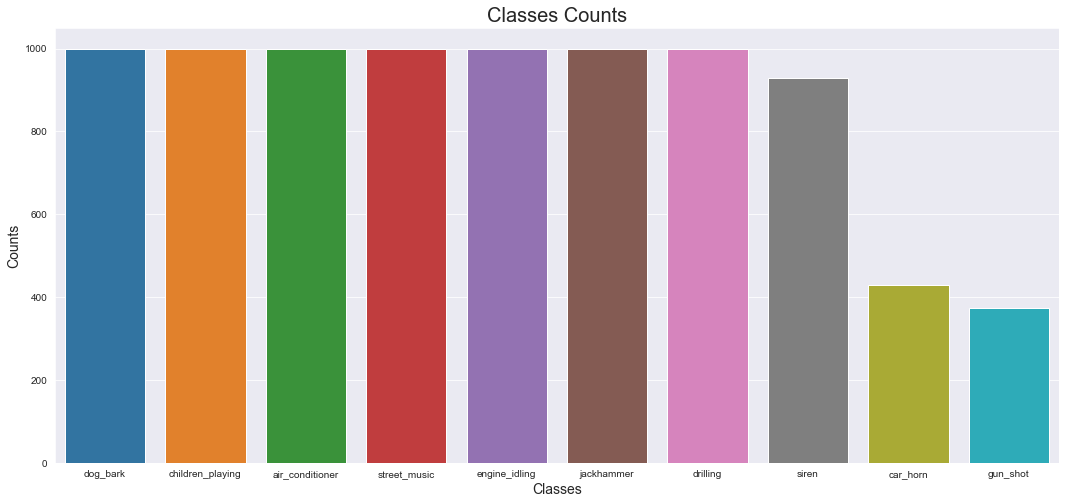

In [6]:
class_vc = dataset.metadata["class"].value_counts()
plt.figure(figsize=(18,8))
sns.barplot(x=class_vc.index, y=class_vc.values)
plt.title("Classes Counts", fontsize=20)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

### Duration of Events

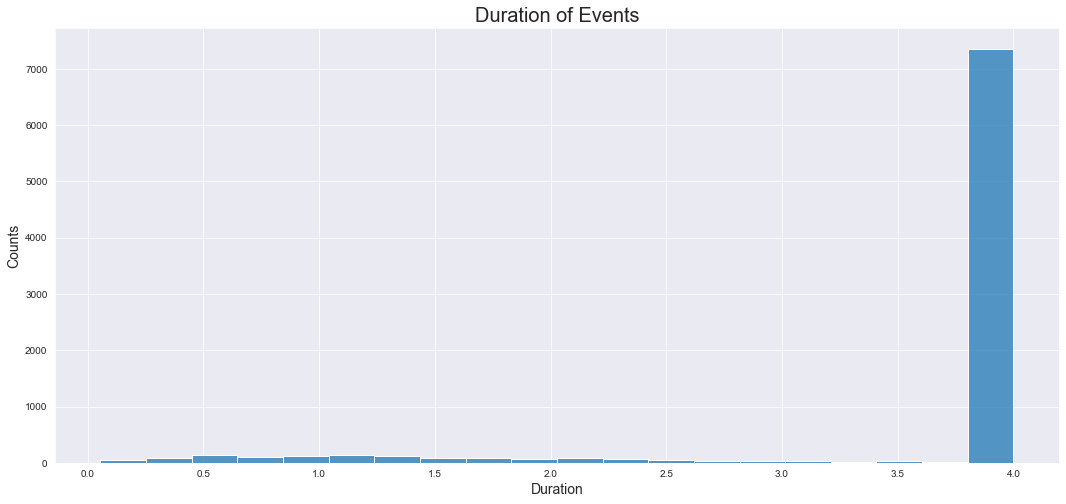

In [7]:
duration = dataset.metadata["end"] - dataset.metadata["start"]
plt.figure(figsize=(18,8))
sns.histplot(data=duration, x=duration.values, bins=20)
plt.title("Duration of Events", fontsize=20)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

### Salience

#### Global

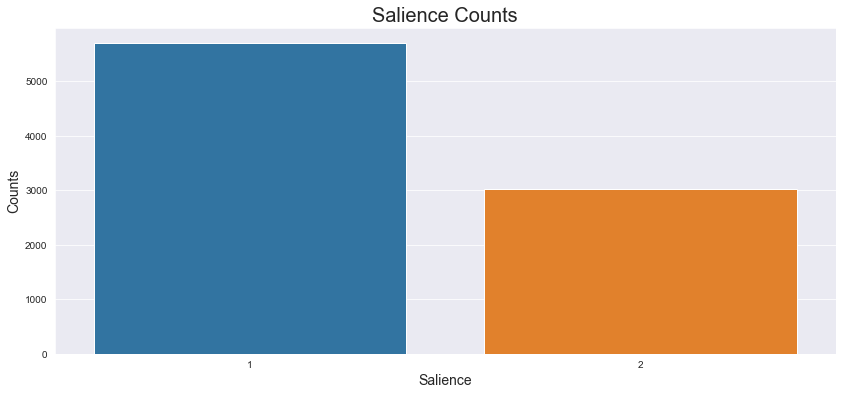

In [8]:
salience_vc = dataset.metadata["salience"].value_counts()
plt.figure(figsize=(14,6))
sns.barplot(x=salience_vc.index, y=salience_vc.values)
plt.title("Salience Counts", fontsize=20)
plt.xlabel("Salience", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

#### Per Class

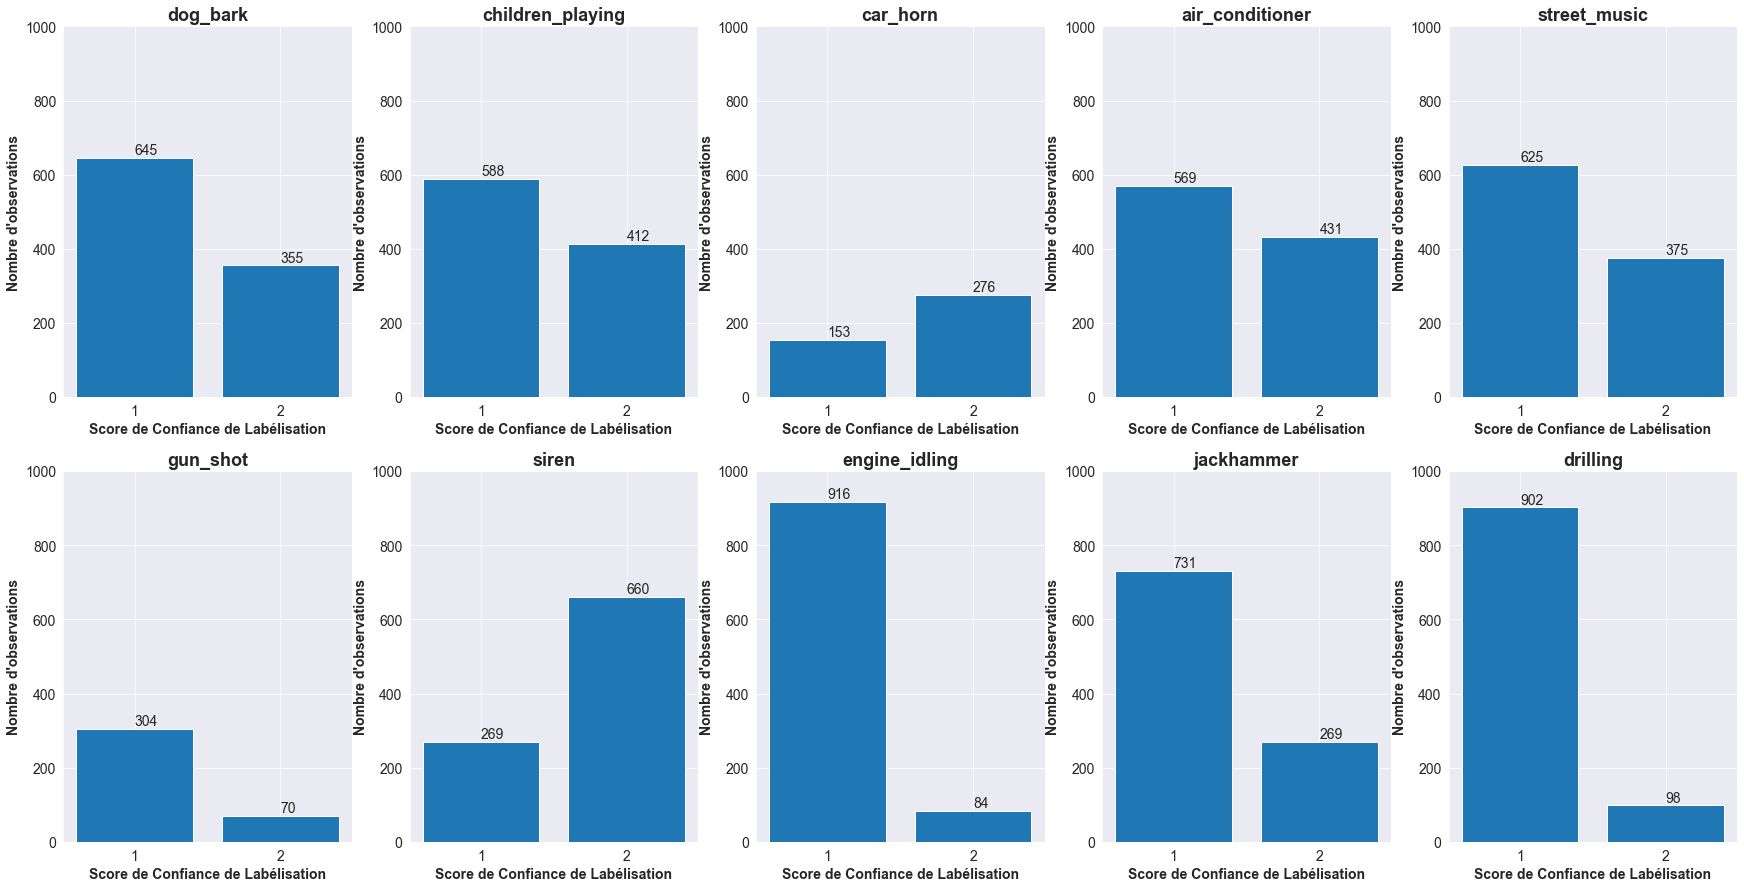

In [9]:
# Set subplot figure parameters
n_cols = 5
n_rows = math.ceil(len(metadata["class"].unique())/n_cols) # Compute the number of rows based on the number of labels and columns
p_count = 1

fig = plt.figure(figsize=(30,15))

# For each unique class
for unique_class in metadata["class"].unique():
    # Filter the metadata based on the label
    filtered_metadata = metadata[metadata["class"]==unique_class]
    # Initialize a dictionnary to count the number events for each salience score
    salience_dict = {1:0, 2:0}
    # For each row of the filtered metadata
    for index, row in filtered_metadata.iterrows():
        # Get the salience score
        salience_score = row[4]
        # Populate the dictionnary
        if salience_score not in salience_dict:
            salience_dict[salience_score] = 1
        else:
            salience_dict[salience_score] += 1
    plt.subplot(n_rows, n_cols, p_count) 
    # Plot a bar graph with all salience scores on the x axis
    plt.bar(range(len(salience_dict)), list(salience_dict.values()), align='center')
    plt.ylim([0, 1000])
    # Write the counts on each bar
    for salience in salience_dict.keys():
        plt.text(salience-1, (filtered_metadata['salience'] == salience).sum()+10, str((filtered_metadata['salience'] == salience).sum()), fontsize=14)
    # Write the ticks on the x axis
    plt.xticks(range(len(salience_dict)), list(salience_dict.keys()), fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"{unique_class}", fontweight="bold", fontsize=18)
    plt.xlabel("Score de Confiance de Labélisation", fontweight="bold", fontsize=14)
    plt.ylabel("Nombre d'observations", fontweight="bold", fontsize=14)
    p_count += 1

plt.show()

### Folds Distribution

In [10]:
# Group by fold and label and pivot
folds_vc = metadata.groupby(["fold", "class"], dropna=False, as_index=False)["class"].size()
folds_vc.pivot(index="class", columns="fold", values="size")

fold,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,
air_conditioner,100,100,100,100,100,100,100,100,100,100
car_horn,36,42,43,59,98,28,28,30,32,33
children_playing,100,100,100,100,100,100,100,100,100,100
dog_bark,100,100,100,100,100,100,100,100,100,100
drilling,100,100,100,100,100,100,100,100,100,100
engine_idling,96,100,107,107,107,107,106,88,89,93
gun_shot,35,35,36,38,40,46,51,30,31,32
jackhammer,120,120,120,120,120,68,76,78,82,96
siren,86,91,119,166,71,74,77,80,82,83


### Visualition of an Event

,slice_file_name,fsID,start,end,salience,fold,classID,class
6399,41918-3-0-0.wav,41918,0.525781,4.525781,1,4,3,dog_bark


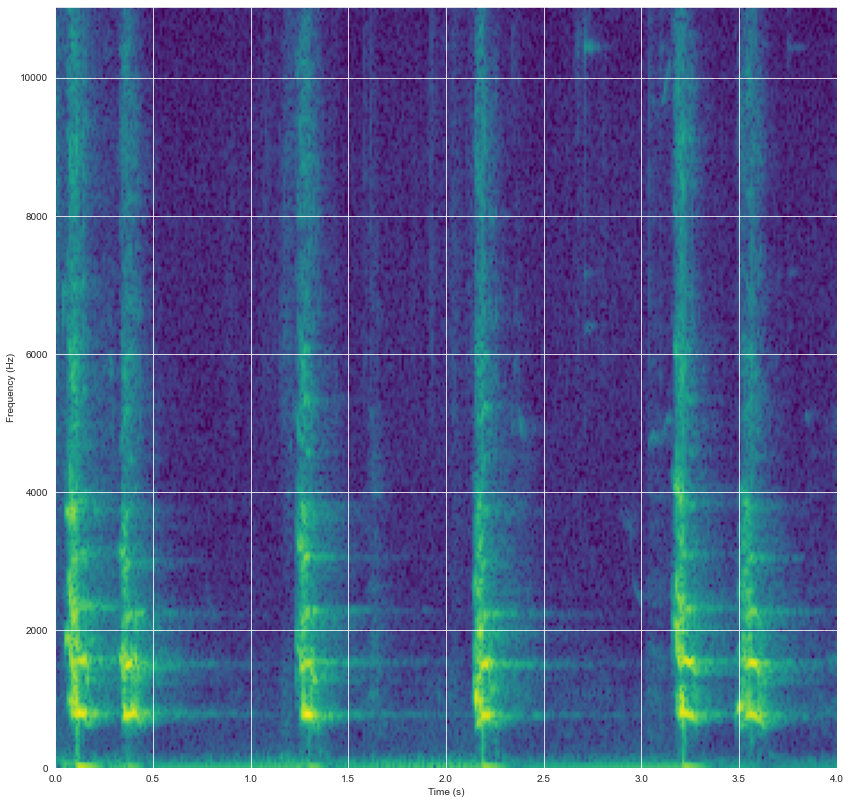

In [11]:
# Input annotations filtering critera
label = "dog_bark"
salience = 1 

# Filter annotations based on criteria
filtered_metadata = dataset.metadata.loc[
    (metadata["class"]==label)
    & (metadata["salience"]==salience)
    ]

# Randomly select the desired number of events from the filtered annotations
selected_event = filtered_metadata.sample(n=1) 
display(selected_event)
selected_event_index = selected_event.index.item()

spectrogram, label = dataset[selected_event_index]

spectrogram = spectrogram.cpu()
spectrogram = torch.squeeze(spectrogram)

plt.figure(figsize=(14,14))
plt.imshow(spectrogram, extent=[0, target_length, 0, target_sample_rate/2], origin="lower", aspect="auto", cmap="viridis")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Build the audio path
selected_event_fold = f"fold{selected_event.iloc[0]['fold']}"
selected_event_filename = selected_event.iloc[0]["slice_file_name"]
selected_audio_path = os.path.join(dataset_path, selected_event_fold, selected_event_filename)
display(IPython.display.Audio(filename=selected_audio_path))

## Creation of the Pipeline

In [12]:
class Pipeline(pl.LightningModule):
    def __init__(self, out_dim, classes_map, lr):
        super().__init__()
        
        # Save hyperparameters to the checkpoint
        self.save_hyperparameters()        

        # Definition of the model
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.3),
            nn.Flatten(),
            nn.Linear(696320, out_dim),
            )
        
        # Instantiation of the metrics
        self.accuracy = Accuracy(num_classes=len(classes_map), average="weighted")
        self.recall = Recall(num_classes=len(classes_map), average="weighted")
        self.f1_score = F1(num_classes=len(classes_map), average="weighted")
        self.confmat = ConfusionMatrix(num_classes=len(classes_map))           
        
        # Instantiation of the classes map
        self.classes_map = classes_map
        
        # Instantiation of the number of classes
        self.n_classes = len(classes_map)
        
        # Instatiation of the learning rate
        self.lr = lr
        
        
    def configure_optimizers(self):
        
        optimizer = Adam(self.parameters(), lr=self.lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
            
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                        "scheduler": scheduler,
                        "monitor": "validation_loss",
                        "frequency": 1
                        }
                }
    
    def forward(self, x):

        logits = self.model(x)
        
        return logits 
    
        
    def training_step(self, train_batch, batch_idx): 
        
        # Unpack the training batch
        inputs, targets = train_batch
        # Pass the inputs to the model to get the logits
        logits = self(inputs)
        # Compute the loss
        loss = F.cross_entropy(logits, targets)
        # Get the probabilities for each class by applying softmax
        probs = F.softmax(logits, dim=1)
        # Get the prediction for each batch sample
        _, preds = torch.max(probs, 1)
        # Compute the accuracy
        accuracy = self.accuracy(logits, targets)
        # Log the loss
        self.log("training_loss", loss, on_step=True, on_epoch=True)
        
        return {"inputs":inputs, "targets":targets, "predictions":preds, "loss":loss}
    
    
    def training_epoch_end(self, outputs):
        
        if self.current_epoch == 0:
            input_height = outputs[0]["inputs"].size()[2]
            input_width = outputs[0]["inputs"].size()[3]
            input_sample = torch.rand((1,1,input_height,input_width)).to(self.device)
            self.logger.experiment.add_graph(self, input_sample)

            
    def validation_step(self, validation_batch, batch_idx):
        
        # Unpack the validation batch
        inputs, targets = validation_batch
        # Pass the inputs to the model to get the logits
        logits = self(inputs)
        # Compute the loss and log it for early stopping monitoring
        loss = F.cross_entropy(logits, targets)
        # Get the probabilities for each class by applying softmax
        probs = F.softmax(logits, dim=1)
        # Get the prediction for each batch sample
        _, preds = torch.max(probs, 1)
        # Compute the accuracy for this batch
        accuracy = self.accuracy(preds, targets)
        # Log the loss and the accuracy
        self.log("validation_loss", loss, on_step=True, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_step=True, on_epoch=True)
        
        return {"inputs":inputs, "targets":targets, "predictions":preds, "loss":loss}
    
    
    def validation_epoch_end(self, outputs):
        
        # Concatenate the predictions of all batches
        preds = torch.cat([output["predictions"] for output in outputs])
        # Concatenate the targets of all batches
        targets = torch.cat([output["targets"] for output in outputs])
        # Compute the confusion matrix, turn it into a DataFrame, generate the plot and log it
        cm = self.confmat(preds, targets)
        cm = cm.cpu()
        
        for class_id in range(self.n_classes):
                precision = cm[class_id, class_id] / torch.sum(cm[:,class_id])
                precision = round(precision.item()*100,1)
                self.log(f"validation_precision/{class_id}",precision)
                recall = cm[class_id, class_id] / torch.sum(cm[class_id,:])
                recall = round(recall.item()*100,1)
                self.log(f"validation_recall/{class_id}",recall)
      
        df_cm = pd.DataFrame(cm.numpy(), index = range(self.n_classes), columns=range(self.n_classes))
        plt.figure()
        fig = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.yticks(rotation=0)
        self.logger.experiment.add_figure("Confusion matrix", fig, self.current_epoch)
        
    def on_save_checkpoint(self, checkpoint):
        # Get the state_dict from self.model to get rid of the "model." prefix
        checkpoint["state_dict"] = self.model.state_dict()

## Model Training and Validation

In [13]:
# Batch size
batch_size = 5
# Number of epochs
n_epochs = 30
# Learning rate
learning_rate = 2e-4

for i in range(1,dataset.n_folds+1):
    
    print(f"========== Cross-validation {i} on {dataset.n_folds} ==========")
    
    # Get the train and validation sets
    train_metadata = dataset.metadata.drop(dataset.metadata[dataset.metadata["fold"]==i].index)
    validation_metadata = dataset.metadata[dataset.metadata["fold"]==i]
    train_indices = train_metadata.index
    validation_indices = validation_metadata.index 
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    # Create the train and validation dataloaders
    train_dataloader = DataLoader(
                            dataset, 
                            batch_size=batch_size, 
                            sampler=train_sampler,
                            )
    
    validation_dataloader = DataLoader(
                            dataset, 
                            batch_size=batch_size,
                            sampler=validation_sampler,
                            )
    
    # Instantiate the pipeline
    pipeline = Pipeline(out_dim=dataset.n_classes, classes_map=dataset.classes_map, lr=learning_rate)
    
    # Instantiate the logger
    run_name = f"{dataset.n_folds} folds cross-validation - Validation on fold {i}"
    tensorboard_logger = TensorBoardLogger(save_dir="logs", name=run_name)
    
    # Instantiate a learning rate monitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    # Instantiate early stopping based on epoch validation loss
    early_stopping = EarlyStopping("validation_loss", patience=6, verbose=True)
    
    # Instantiate a checkpoint callback
    checkpoint = ModelCheckpoint(
                            dirpath=f"./checkpoints/{dataset.n_folds} folds cross-validation - Validation on fold {i}",
                            filename="{epoch}-{validation_loss:.2f}",
                            verbose=True,
                            monitor="validation_loss",
                            save_last = False,
                            save_top_k=1,      
                            mode="min",
                            save_weights_only=True
                            )
    
    # Instantiate the trainer and train the model
    trainer = Trainer(
                    gpus=-1,
                    max_epochs=n_epochs, 
                    logger=tensorboard_logger,
                    log_every_n_steps = 1,
                    callbacks=[early_stopping, lr_monitor, checkpoint]
                    )   
    
    trainer.fit(pipeline, train_dataloader, validation_dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


========== Cross-validation 1 on 10 ==========



  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:458: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\torch\_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
C:\Users\APU\anaconda3\lib\site-packages\torch\_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
C:\Users\APU\anaconda3\lib\site-packages\torch\_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
Metric validation_loss improved. New best score: 1.837
Epoch 0, global step 1571: validation_loss reached 1.83674 (best 1.83674), saving model to "C:\Users\APU\Projects\UrbanSound8K\check

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.076 >= min_delta = 0.0. New best score: 1.761
Epoch 1, global step 3143: validation_loss reached 1.76113 (best 1.76113), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 1\epoch=1-validation_loss=1.76.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.126 >= min_delta = 0.0. New best score: 1.636
Epoch 2, global step 4715: validation_loss reached 1.63563 (best 1.63563), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 1\epoch=2-validation_loss=1.64.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6287: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7859: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9431: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 11003: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 12575: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.636. Signaling Trainer to stop.
Epoch 8, global step 14147: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 2 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.598
Epoch 0, global step 1568: validation_loss reached 1.59837 (best 1.59837), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=0-validation_loss=1.60.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.115 >= min_delta = 0.0. New best score: 1.484
Epoch 1, global step 3137: validation_loss reached 1.48368 (best 1.48368), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=1-validation_loss=1.48.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 4706: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.454
Epoch 3, global step 6275: validation_loss reached 1.45382 (best 1.45382), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 2\epoch=3-validation_loss=1.45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7844: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9413: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 10982: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 12551: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 14120: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.454. Signaling Trainer to stop.
Epoch 9, global step 15689: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 3 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.731
Epoch 0, global step 1561: validation_loss reached 1.73096 (best 1.73096), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 3\epoch=0-validation_loss=1.73.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.636
Epoch 1, global step 3123: validation_loss reached 1.63562 (best 1.63562), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 3\epoch=1-validation_loss=1.64.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.618
Epoch 2, global step 4685: validation_loss reached 1.61790 (best 1.61790), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 3\epoch=2-validation_loss=1.62.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6247: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7809: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9371: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 10933: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 12495: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.618. Signaling Trainer to stop.
Epoch 8, global step 14057: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 4 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.847
Epoch 0, global step 1548: validation_loss reached 1.84747 (best 1.84747), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 4\epoch=0-validation_loss=1.85.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.173 >= min_delta = 0.0. New best score: 1.674
Epoch 1, global step 3097: validation_loss reached 1.67421 (best 1.67421), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 4\epoch=1-validation_loss=1.67.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.670
Epoch 2, global step 4646: validation_loss reached 1.67008 (best 1.67008), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 4\epoch=2-validation_loss=1.67.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6195: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7744: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9293: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 10842: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 12391: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.670. Signaling Trainer to stop.
Epoch 8, global step 13940: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 5 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.773
Epoch 0, global step 1559: validation_loss reached 1.77302 (best 1.77302), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 5\epoch=0-validation_loss=1.77.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.209 >= min_delta = 0.0. New best score: 1.564
Epoch 1, global step 3119: validation_loss reached 1.56413 (best 1.56413), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 5\epoch=1-validation_loss=1.56.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 4679: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6239: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7799: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9359: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 10919: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.564. Signaling Trainer to stop.
Epoch 7, global step 12479: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 6 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.928
Epoch 0, global step 1581: validation_loss reached 1.92823 (best 1.92823), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 6\epoch=0-validation_loss=1.93.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.133 >= min_delta = 0.0. New best score: 1.795
Epoch 1, global step 3163: validation_loss reached 1.79484 (best 1.79484), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 6\epoch=1-validation_loss=1.79.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 4745: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6327: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7909: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9491: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 11073: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.795. Signaling Trainer to stop.
Epoch 7, global step 12655: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 7 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.630
Epoch 0, global step 1578: validation_loss reached 1.63049 (best 1.63049), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=0-validation_loss=1.63.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.562
Epoch 1, global step 3157: validation_loss reached 1.56236 (best 1.56236), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=1-validation_loss=1.56.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.546
Epoch 2, global step 4736: validation_loss reached 1.54584 (best 1.54584), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=2-validation_loss=1.55.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6315: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.468
Epoch 4, global step 7894: validation_loss reached 1.46813 (best 1.46813), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 7\epoch=4-validation_loss=1.47.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9473: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 11052: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 12631: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 14210: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 15789: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.468. Signaling Trainer to stop.
Epoch 10, global step 17368: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 8 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.655
Epoch 0, global step 1585: validation_loss reached 1.65519 (best 1.65519), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 8\epoch=0-validation_loss=1.66.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.140 >= min_delta = 0.0. New best score: 1.515
Epoch 1, global step 3171: validation_loss reached 1.51547 (best 1.51547), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 8\epoch=1-validation_loss=1.52.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 4757: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6343: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7929: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9515: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 11101: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.515. Signaling Trainer to stop.
Epoch 7, global step 12687: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 9 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.631
Epoch 0, global step 1583: validation_loss reached 1.63058 (best 1.63058), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 9\epoch=0-validation_loss=1.63.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.167 >= min_delta = 0.0. New best score: 1.464
Epoch 1, global step 3167: validation_loss reached 1.46365 (best 1.46365), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 9\epoch=1-validation_loss=1.46.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.399
Epoch 2, global step 4751: validation_loss reached 1.39949 (best 1.39949), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 9\epoch=2-validation_loss=1.40.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6335: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7919: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9503: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 11087: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 12671: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.399. Signaling Trainer to stop.
Epoch 8, global step 14255: validation_loss was not in top 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | model    | Sequential      | 7.2 M 
1 | accuracy | Accuracy        | 0     
2 | recall   | Recall          | 0     
3 | f1_score | F1              | 0     
4 | confmat  | ConfusionMatrix | 0     
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.679    Total estimated model params size (MB)


========== Cross-validation 10 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 1.454
Epoch 0, global step 1578: validation_loss reached 1.45389 (best 1.45389), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 10\epoch=0-validation_loss=1.45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 3157: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.448
Epoch 2, global step 4736: validation_loss reached 1.44834 (best 1.44834), saving model to "C:\Users\APU\Projects\UrbanSound8K\checkpoints\10 folds cross-validation - Validation on fold 10\epoch=2-validation_loss=1.45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6315: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7894: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9473: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 11052: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 12631: validation_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 6 records. Best score: 1.448. Signaling Trainer to stop.
Epoch 8, global step 14210: validation_loss was not in top 1


In [17]:
%load_ext tensorboard
%tensorboard --logdir logs --host localhost

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17428), started 0:02:05 ago. (Use '!kill 17428' to kill it.)